1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize,curve_fit

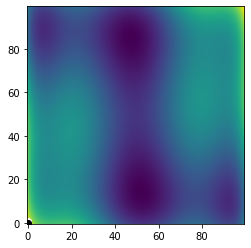

result for x0=[0.2,0.2]: [-0.08984203  0.71265604]
*********
result for x0=[0,0]  [0. 0.]


In [15]:
#inputs
x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
x_in,y_in = np.meshgrid(x,y)

f_x_y = lambda x: (4-(2.1)*(x[0]**2) + ((x[0]**4) / 3))*(x[0]**2) + x[0]*x[1] + (4*(x[1]**2)-4)*(x[1]**2)


func_result = f_x_y([x_in,y_in])

## plotting 
plt.figure()
# as suggested in the question
plt.imshow(func_result,origin="lower")

x0=[0.2,0.2]
x1=[0, 0]
res = minimize(f_x_y, x0) # Global minima
plt.scatter(res.x[0], res.x[1], color='white')
res2 = optimize.minimize(f_x_y, x1) # (𝑥,𝑦)=(0,0)
plt.scatter(res2.x[0], res2.x[1], color='black')
plt.show()

# res has a solution array called 'x'
print("result for x0=[0.2,0.2]:",res['x'])
print("*********")
print("result for x0=[0,0] ",res2['x'])

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

the fit function: 18.045379 * sin( 3.172777 * x) + 15
the fit function: 25.115800 * sin( 2.093235 * (x - 0.667865)) - 35


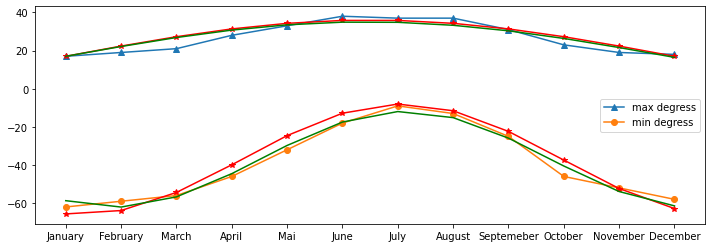

In [88]:
max_degress= [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
min_degrees = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months= ['January', 'February', 'March', 'April', 'Mai', 'June', 'July', 'August', 'Septemeber', 'October', 'November', 'December']

#1
f = plt.figure()
f.set_figwidth(12)
plt.plot(months,max_degress,label='max degress',marker='^')
plt.plot(months,min_degrees,label='min degress',marker='o')
plt.legend()

#2
x_data = np.linspace(0,1,12) # x needs to have the same dimension = 12
y_data_max = 19* np.sin(np.pi * x_data) + 17 # adjusted the coefficients by trial
plt.plot(months,y_data_max, 'r',marker='*')

y_data_min = 29* np.sin(np.pi * (1.9*x_data-0.55)) - 37 # adjusted the coefficients by trial
plt.plot(months,y_data_min, 'r',marker='*')

#3
def fitted_max(x, A, nu):
    return (A * np.sin(nu * x) + 17) # sine function with amplitude A and angular frequency

def fitted_min (x, A, nu,phi):
    return (A * np.sin(np.pi * (nu * x - phi)) - 37)
#*****************
popt, pcov = optimize.curve_fit(fitted_max, x_data, max_degress, p0=[2, 2], full_output=False)
print('the fit function: %f * sin( %f * x) + 15'% (popt[0],popt[1]) )
plt.plot(months,fitted_max(x_data,popt[0],popt[1]), 'g')
#*****************
popt_min, pcov_min = optimize.curve_fit(fitted_min, x_data, min_degrees, p0=[2, 2, 0.4], full_output=False)
print('the fit function: %f * sin( %f * (x - %f)) - 35'% (popt_min[0],popt_min[1],popt_min[2]) )
plt.plot(months,fitted_min(x_data,popt_min[0],popt_min[1],popt_min[2]), 'g')
plt.show()
#*****************
#4, #5
#Fitted functions really fit the dataset. Therefore, yes they were reasonable.
#The offsets were close to the fitted ones

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

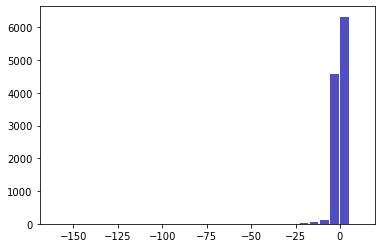

In [95]:
#1
residuals_261 = np.load('residuals_261.pkl', allow_pickle=True)
df=pd.DataFrame(residuals_261.item())
plt.figure()
n, bins, patches = plt.hist(df['residuals'], bins=30, color='#0504aa', alpha=0.7, rwidth=0.85)

#2
sigma=[]
border=[]
value=[]
for pp in patches:
    value.append(pp._y1)
    sigma.append( np.sqrt(pp._y1) )    
    if not(pp._x0 in border):
        border.append(pp._x0)
    border.append(pp._x1)

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

The best-fit values for f: a:-10.018001,  b:12.325492,  c:9.351029 

The overall average temperature: 9.351029 

The typical daily average values for the coldest and hottest time of year: -0.666971 and 19.369030 

The best-fit values for g are: a:-10.019988,  b:0.999570,  c:5.192768,  d:9.346839 



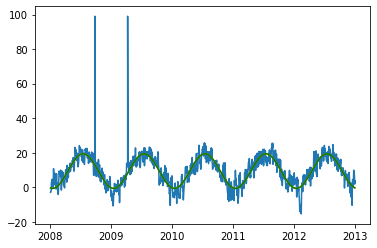

RSS of f(x) is :40376.572228 

RSS of g(x) is : 40375.279977 

CL: 0.809 , additional parameter necessary: NO


In [135]:
file_name= "munich_temperatures_average_with_bad_data.txt"
data = pd.read_csv(file_name, delimiter=' ')
data.to_csv (r'munich_temperatures_average_with_bad_data.csv', index=None)

headers = ['Year','Temperature']
df = pd.read_csv("munich_temperatures_average_with_bad_data.csv", names = headers)
df

#1
df = df[(df['Year'] >= 2008) & (df['Year'] < 2013)] 
plt.figure()
plt.plot(df['Year'], df['Temperature'])

#2
func = lambda x,a,b,c: a*np.cos(2*(np.pi)*x+b)+c
popt, pcov = curve_fit(func, df['Year'], df['Temperature'], p0=[1, 1, 5], full_output=False)
plt.plot(df['Year'],func(df['Year'],popt[0],popt[1],popt[2]))
print('The best-fit values for f: a:%f,  b:%f,  c:%f \n'%(popt[0],popt[1], popt[2]))

#3
print('The overall average temperature: %f \n'%(popt[2]))
print('The typical daily average values for the coldest and hottest time of year: %f and %f \n'%(popt[0]+popt[2],popt[2]-popt[0]))

#4
#b parameter, changes the angle for the cos funct, in that, it is shifted to the right or left depending on the value of b


#5 
g = lambda x,a,b,c,d: a * np.cos(2 * np.pi * b * x + c) + d

gopt, gcov = curve_fit(g, df['Year'], df['Temperature'], p0=[1, 1, 5,5], full_output=False)
plt.plot(df['Year'],g(df['Year'],gopt[0],gopt[1],gopt[2],gopt[3]), 'g')
print('The best-fit values for g are: a:%f,  b:%f,  c:%f,  d:%f \n'%(gopt[0],gopt[1], gopt[2],gopt[3]))
plt.show()
#6 RSS
RSS_func = np.sum((df['Temperature'] - func(df['Year'],popt[0],popt[1],popt[2]))**2)
RSS_g = np.sum((df['Temperature'] - g(df['Year'],gopt[0],gopt[1],gopt[2],gopt[3]))**2)
print('RSS of f(x) is :%f \n' % RSS_func)
print('RSS of g(x) is : %f \n'% RSS_g)

#7 Fisher F-test
# taken from lecture notes
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL
ndof_func = 3-1
ndof_g = 4-1
cl_func_vs_g = Ftest(RSS_func, RSS_g, ndof_func, ndof_g, len(df['Year']), verbose=True)
